In [1]:
import os
import sys

HOME = os.path.abspath('../src')
sys.path.append(HOME)
os.chdir(HOME)

import torchvision
import dlib
from PIL import Image
from imutils import face_utils
from data.dataprep_mediapipe import VideoProcessor
from utils.data_handler import read_pickle, save_to_pickle
import pandas as pd
import seaborn as sns

In [2]:
IMG_SIZE=224
input_directory = '../data/raw'
output_directory = '../data/processed'
video_processor = VideoProcessor(input_directory,
                                 output_directory)

In [3]:
video_list = video_processor.video_filter(output_directory,
                                          extension='pkl',
                                          video_type='face_smile'
                                         )


video_list = sorted(video_list,key=lambda x: int(x.split('_')[0])) #sort by patient id

In [4]:
df_fast = pd.read_csv('../data/raw/FASTr_DATA_2022-04-01_1658.csv')
ground_truths = [i for i in df_fast.columns if '_ground_truth' in i]

for c in ground_truths:
    df_fast.loc[(df_fast[c].isna())\
                &(df_fast['diagnosis']==0),
                c] = 0

In [5]:
id_labels = {row['record_id']:row['f_ground_truth'] for _,row in df_fast[['record_id','f_ground_truth']].iterrows()}

In [6]:
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


def get_dataset(video_list,id_labels,transform,batch_size,shuffle,input_directory,output_directory):
    df = []

    num_videos = len(video_list)

    all_patients_frames = [] 
    for v in video_list:
        print(v)
        id_label = id_labels[int(v.split('_')[0])]

        if not np.isnan(id_label):
            patient = read_pickle(os.path.join(output_directory,v))
            #patient_frames = np.array([i['frame'] for i in patient])
            patient_frames =[i['frame'].astype(float) for i in patient]
            all_patients_frames.append({'id':v.split('.')[0],
                                        'frames':patient_frames,
                                        'labels':np.repeat(float(id_label),len(patient_frames)).tolist()})
            
    #Get list of frames and list of targets
    all_frames_all_patients = [j.transpose([2,1,0]) for i in all_patients_frames for j in i['frames']]
    all_labels_all_patients = [j for i in all_patients_frames for j in i['labels']]
    
    

    dataset = MyDataset(all_frames_all_patients, all_labels_all_patients, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=shuffle)
    print('done')
    return dataloader

In [7]:
train_videos, temp_videos = train_test_split(video_list,test_size=0.4,random_state=42)
val_videos, test_videos = train_test_split(temp_videos,test_size=0.5,random_state=42)

In [8]:
transform_train = transforms.Compose(
    [   transforms.Resize((IMG_SIZE,IMG_SIZE)), #TODO: This could be rermoved
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),#TODO: This could be rermoved
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

batch_size = 32
shuffle = True
input_directory = '../data/raw'
output_directory = '../data/processed'


train_dataloader = get_dataset(train_videos,id_labels,transform_train,batch_size,shuffle,input_directory,output_directory)
val_dataloader = get_dataset(val_videos,id_labels,transform_test,batch_size,shuffle,input_directory,output_directory)
test_dataloader = get_dataset(test_videos,id_labels,transform_test,batch_size,shuffle,input_directory,output_directory)



55_face_smile.pkl
81_face_smile.pkl
25_face_smile.pkl
69_face_smile.pkl
31_face_smile.pkl
48_face_smile.pkl
17_face_smile.pkl
61_face_smile.pkl
7_face_smile.pkl
23_face_smile.pkl
44_face_smile.pkl
12_face_smile.pkl
67_face_smile.pkl
10_face_smile.pkl
42_face_smile.pkl
75_face_smile.pkl
62_face_smile.pkl
52_face_smile.pkl
80_face_smile.pkl
20_face_smile.pkl
33_face_smile.pkl
47_face_smile.pkl
32_face_smile.pkl
54_face_smile.pkl
30_face_smile.pkl
49_face_smile.pkl
74_face_smile.pkl
63_face_smile.pkl
15_face_smile.pkl
38_face_smile.pkl
79_face_smile.pkl
65_face_smile.pkl
72_face_smile.pkl
43_face_smile.pkl
35_face_smile.pkl
5_face_smile.pkl
58_face_smile.pkl
27_face_smile.pkl
6_face_smile.pkl
29_face_smile.pkl
26_face_smile.pkl
66_face_smile.pkl
77_face_smile.pkl
18_face_smile.pkl
57_face_smile.pkl
done
41_face_smile.pkl
14_face_smile.pkl
60_face_smile.pkl
3_face_smile.pkl
46_face_smile.pkl
37_face_smile.pkl
40_face_smile.pkl
78_face_smile.pkl
36_face_smile.pkl
59_face_smile.pkl
73_face_s

In [9]:
#!pip install wwf
#!pip install timm==0.4.5

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

Using cpu device


In [11]:
import torch
from tensorflow.keras.models import load_model

def set_parameter_requires_grad(model,
                                feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_outputs,
                     feature_extract):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = torch.load('../../face-emotion-recognition/models/affectnet_emotions/enet_b0_8_best_afew.pt',
                          map_location='cpu')
    
    set_parameter_requires_grad(model_ft, feature_extract)

    num_ftrs = 1280
    model_ft.classifier = torch.nn.Linear(num_ftrs, num_outputs)

    #model_ft.fc.bias.data
    return model_ft



In [12]:
num_epochs = 3
lr = 1e-3
feature_extract = True
net = initialize_model(2,feature_extract)

net = net.to(device)
criterion = torch.nn.CrossEntropyLoss()


params_to_update = net.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


optimizer = torch.optim.AdamW(net.parameters(),
                      lr=lr,
                      weight_decay=0.001
                      )

#scheduler = torch.optim.lr_scheduler.CosianeAnnealingLR(optimizer,T_max=200)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


Params to learn:
	 classifier.weight
	 classifier.bias


In [13]:
resume = False
if resume:
    # Load checkpoint.
    '''
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']'''
    net, optimizer, scheduler,best_acc, start_epoch = load_ckpt(net,optimizer,scheduler,root = root)


# Training
def train(epoch,dataloader,net,optimizer):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
        if batch_idx % 100 == 0:
              loss, current = loss.item(), batch_idx * len(inputs)
              print(f"loss: {loss:>7f}  [{current:>5d}/{total:>5d}]")

              

def test(epoch,dataloader,net,optimizer,save_ckpts = True):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= num_batches
    acc = 100.*correct/total 

    print(f"Test Error: \n Accuracy: {(acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    if save_ckpts:
      # Save checkpoint.
      if acc > best_acc:
        best_acc = save_ckpt(epoch,net,acc,optimizer,scheduler,file_name = 'ckpt.pth',root = root)
      
      if epoch % 10 == 0:
        _ = save_ckpt(epoch,net,acc,optimizer,scheduler,file_name = f'ckpt_epoch_{epoch}.pth',root = root)
      

      


for epoch in range(start_epoch, num_epochs):
    train(epoch,train_dataloader,net,optimizer)
    test(epoch,val_dataloader,net,optimizer)
    scheduler.step()


Epoch: 0


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


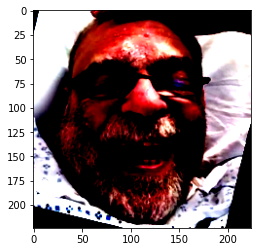

In [18]:
a=next(iter(train_dataset))[0][16].transpose(0,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


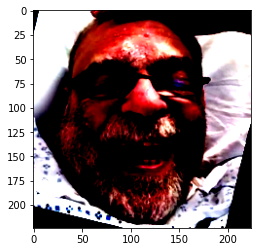

In [24]:
plt.imshow(a)

In [26]:
emotion_to_index = {'Anger': 0, 
                    'Contempt': 1,
                    'Disgust': 2,
                    'Fear': 3,
                    'Happiness': 4,
                    'Neutral': 5,
                    'Sadness': 6,
                    'Surprise': 7}